<a href="https://colab.research.google.com/github/pmckim1/NLP_News_Project/blob/main/NLP_BERT_FULL_DATASET_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with BERT

In [1]:
!pip install hdbscan
!pip install sentence_transformers
!pip install umap --upgrade
!pip install bertopic
!pip install 'umap-learn==0.3.10'

     |████████████████████████████████| 4.7MB 8.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301814 sha256=69213ed3b5ff466dc7ba536d16ee8857c75d02de7d144111983fa5607636bc8c
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 1.3MB 15.0MB/s 
     |████████████████████████████████| 1.1MB 30.7MB/s 
     |████████████████████████████████| 890kB 33.3MB/s 
     |████████████████████████████████| 2.9MB 53.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101035 sha256=5ae177139942fbb38174e3d74ab0bf06e893c59d373f0b566d2bf92b7485113e
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f

In [2]:
!pip install 'umap-learn==0.3.10'

In [6]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import nltk
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from bertopic import BERTopic
import bertopic

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Load data


In [7]:
np.random.seed(42)
from google.colab import drive
import json 
import sys
import pandas as pd
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/nlpproj/'

data_set = pd.read_csv(abspath_curr +'combined_news.csv', header=0)

len(data_set)
#data = data_set
data = data_set["text"].to_list()


Mounted at /content/drive


In [8]:
len(data_set)

3073

In [9]:
print(data[9:10])

['The EU has launched legal action against the UK after Boris Johnson failed to respond to Brussels’ demand that he drop legislation that would overwrite the withdrawal agreement and break international law. Ursula von der Leyen, the European commission president, announced that the UK had been put on formal notice over the internal market bill tabled by the prime minister last month. Meanwhile, EU officials downplayed hopes that ongoing trade and security talks were closing in on solutions to the most contentious issues. The Dutch prime minister, Mark Rutte, arriving at a summit in Brussels, suggested the negotiations could drag deep into October or beyond, saying it would be “nice” to get a “general outline and the details of a deal ready” before the end of the month. Brussels had given Johnson until the end of September to drop the contentious clauses in the internal market bill, through which the prime minister is seeking to allow ministers to unilaterally change a protocol relatin

## Create embeddings
convert the documents to numerical data with **BERT**



In [10]:
%%time


from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# create embeddings for future customized bert topic model 
sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens")
embeddings = sentence_model.encode(data_set["text"], show_progress_bar=False)

# Create BERT out of the box topic model
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(data_set["text"], embeddings)
'''
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data_set["text"], show_progress_bar=True)
'''
print(topics)

100%|██████████| 245M/245M [00:26<00:00, 9.19MB/s]
2020-12-18 18:16:05,274 - BERTopic - Reduced dimensionality with UMAP
INFO:BERTopic:Reduced dimensionality with UMAP
2020-12-18 18:16:05,559 - BERTopic - Clustered UMAP embeddings with HDBSCAN
INFO:BERTopic:Clustered UMAP embeddings with HDBSCAN


[3, 3, -1, 6, -1, -1, -1, -1, 5, 5, -1, -1, -1, -1, 6, 0, -1, 1, -1, -1, 1, 1, -1, 5, -1, -1, -1, -1, 3, -1, 0, -1, -1, -1, 6, 5, -1, -1, -1, -1, 3, -1, -1, -1, 3, 3, 3, 3, -1, -1, -1, -1, -1, -1, 1, 7, 6, -1, -1, 3, 5, -1, 8, 6, 5, -1, 4, 1, -1, -1, 5, -1, 5, -1, -1, 1, -1, -1, -1, 5, -1, -1, 1, 5, 6, 1, -1, 3, 3, 3, -1, 5, 1, -1, 4, -1, 1, 5, -1, -1, -1, -1, 5, 7, 8, -1, 4, 3, 1, -1, -1, 5, 3, 1, -1, 7, -1, 5, -1, 5, 4, 1, -1, -1, -1, 4, 0, -1, 1, 2, 4, 5, -1, 6, -1, 3, -1, 7, -1, 1, 3, -1, 3, 1, -1, 3, -1, 7, -1, -1, 3, -1, -1, 1, -1, -1, 4, -1, 6, -1, 7, -1, 1, -1, -1, 7, 3, -1, 1, 6, 8, -1, -1, -1, 5, -1, -1, -1, 5, 5, 2, 1, -1, 3, 3, 3, 1, 3, -1, 1, -1, 5, -1, -1, -1, -1, -1, -1, -1, 5, -1, 7, -1, 5, 6, 1, -1, 8, 0, -1, 5, 1, -1, 5, 1, -1, 1, -1, 5, -1, -1, -1, -1, -1, -1, 1, 1, -1, 5, 1, -1, 0, 3, 1, -1, 6, 2, -1, -1, 5, -1, -1, -1, -1, 3, 1, -1, 3, 6, -1, -1, -1, -1, -1, -1, -1, 2, 6, 5, -1, 1, 6, 2, 5, -1, 1, 6, -1, -1, -1, 5, -1, 0, 1, 1, 6, -1, 5, -1, 6, -1, -1, -1, 5, -1, -

In [11]:
#out of the box BertTopic Model 
# only 8 topics generated :( not enough for our purposes 
model.get_topics()	

{-1: [('china', 0.001012872716506363),
  ('zealand', 0.0009193324717932975),
  ('women', 0.0008214705559118968),
  ('back', 0.0008137588814417661),
  ('black', 0.0007929331009832936),
  ('vote', 0.0007909104903561224),
  ('re', 0.0007791742168423244),
  ('city', 0.0007615972624830448),
  ('election', 0.0007556644026428628),
  ('don', 0.0007536114463348112),
  ('like', 0.0007526339259871829),
  ('children', 0.0007503215481294164),
  ('test', 0.0007495393971080895),
  ('come', 0.0007472686696545604),
  ('guardian', 0.0007459779176735039),
  ('chinese', 0.0007459216485339384),
  ('australia', 0.0007457294356212295),
  ('leader', 0.0007437397581035112),
  ('hong', 0.0007404893529337244),
  ('way', 0.0007393691793525437)],
 0: [('vaccine', 0.00841226418736321),
  ('vaccines', 0.00654553971227974),
  ('pfizer', 0.0058084293334572925),
  ('trials', 0.005642186177233842),
  ('doses', 0.005129858602321486),
  ('moderna', 0.004814586134008579),
  ('oxford', 0.004629867315474607),
  ('biontech', 

## Reduce dimensionality
We use **UMAP** to reduce the dimensionality of the embeddings created for customized berttopic model mentioned above. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [12]:
%%time
'''
nn=3
n_components = 5
'''

umap_embeddings = umap.UMAP(n_neighbors=4,
                            n_components=6,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings)
          

CPU times: user 5.46 s, sys: 222 ms, total: 5.68 s
Wall time: 5.32 s


## Cluster documents
Use **HDBSCAN** to find highly-densed clusters. **minimum cluster size** enables us to decrease the number of topics found and increase the topic sizes and vice-versa.  We want smaller localized clusters 

In [13]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 141 ms


## Visualize Clusters
Visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Gray are outliers

Text(0.5, 1.0, 'Topic Clusters Produced by BERT Topic Modeling and HDBSCAN after Dimension Reduction')

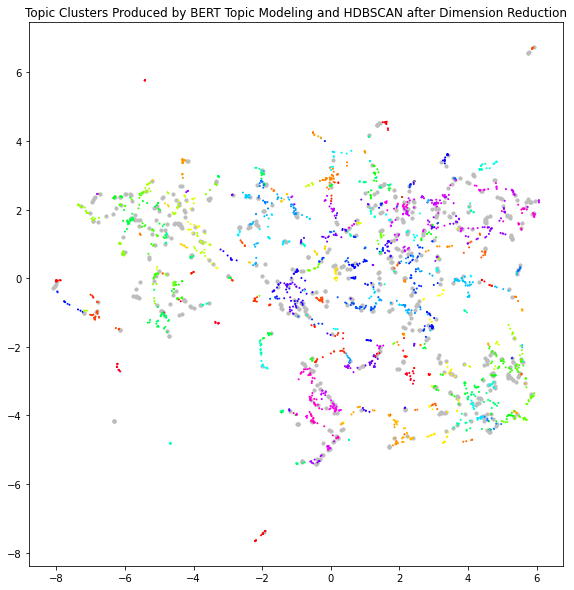

In [28]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=3, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='gist_rainbow')
#plt.colorbar()
ax.axis('scaled')
import matplotlib.cm as cm
plt.title("Topic Clusters Produced by BERT Topic Modeling and HDBSCAN after Dimension Reduction")
# plt.savefig("result1.png", dpi = 300)

## Prepare results
For easier selection, we put the results in a pandas dataframe. 

In [16]:

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})




## Calculate word importance per topic
Calculate the importance of words  in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then extract the words with the highest values in each cluster as a representative of a topic. 

In [17]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))

In [18]:
# n= how many words to return 
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes

,Topic,Size
0,-1,653
177,176,39
37,36,37
282,281,30
2,1,25
...,...,...
172,171,3
235,234,3
121,120,3
119,118,3


In [19]:
print(top_n_words)


{-1: [('countries', 0.0017630879333893055), ('eu', 0.0016892412231282882), ('starmer', 0.0015814038927762287), ('police', 0.0015565343020380357), ('decision', 0.001519210923491626), ('security', 0.0015074796856856594), ('months', 0.0015050300251093973), ('report', 0.0015019347379899644), ('city', 0.0014919638354297321), ('law', 0.0014919495498160256), ('far', 0.0014908995774935584), ('vaccines', 0.0014677786290771201), ('vaccine', 0.0014567554591937257), ('used', 0.001455135830071754), ('officials', 0.0014302530387580697), ('test', 0.0014285873887493112), ('think', 0.0014190727985927975), ('possible', 0.0014160114892433563), ('labour', 0.0014144390398819055), ('states', 0.0014091267759157456), ('right', 0.0013882835867367765), ('end', 0.0013847478279019098), ('use', 0.0013808961641142423), ('continue', 0.0013749880563298069), ('case', 0.001366272248832639), ('christmas', 0.0013650384847885763), ('did', 0.0013643921551366376), ('plan', 0.001356863243737933), ('authorities', 0.0013503685

In [20]:
print(top_n_words[176])
print(len(top_n_words))

[('crece', 0.033642571794254506), ('america', 0.030779934328262225), ('bri', 0.029567062051670284), ('latin', 0.026977626833724625), ('verdict', 0.02120882227791977), ('photographer', 0.01969149733178144), ('chinese', 0.018931974789873775), ('cummings', 0.017797884999302186), ('infrastructure', 0.01669701412025245), ('invest', 0.01668146553064836), ('soutar', 0.01642605988972127), ('projects', 0.014717000272220832), ('pompeo', 0.013141259245569015), ('china', 0.012181736612759456), ('chancellor', 0.011413775482659991), ('suriname', 0.010950706593147511), ('firms', 0.01072884857472622), ('panama', 0.010496232545040432), ('visual', 0.01014371508640819), ('centralising', 0.01014371508640819), ('growth', 0.010017684542713467), ('prompted', 0.009921202002871186), ('tough', 0.009897534793616346), ('investment', 0.009736649831760874), ('holder', 0.009612163369787001), ('parsons', 0.009401213302449682), ('achieved', 0.009287999284258705), ('innovative', 0.008634218332810344), ('argue', 0.00850

## Topic Reduction

In [21]:
for i in tqdm(range(10)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


,Topic,Size
0,-1,663
168,167,39
37,36,37
272,271,30
2,1,25
...,...,...
36,35,4
118,117,4
22,21,4
107,106,4


## Explore Top Clusters 

In [30]:
print(top_n_words)
print(len(topic_sizes))
print(json.dumps(top_n_words[167], indent=1))

#for i in top_n_words:
 # print(json.dumps(top_n_words[i], indent=1))

{-1: [('countries', 0.0017220014821887732), ('eu', 0.0016428249218893118), ('city', 0.0015680867570880307), ('months', 0.0015443015938354898), ('starmer', 0.0015379507029874683), ('police', 0.0015252905944115802), ('security', 0.0015143893303516823), ('decision', 0.0014938829435620056), ('far', 0.001472707049789933), ('report', 0.00146066517015955)], 0: [('fires', 0.033938505721908575), ('wildfires', 0.031216183935649705), ('smoke', 0.025868460953023035), ('richardson', 0.024607415877695472), ('frazee', 0.02326869216207487), ('loh', 0.020816957913746922), ('wildfire', 0.018972883864319348), ('land', 0.018777157727104865), ('paraguay', 0.01869903295830041), ('rosa', 0.01710611432490987)], 1: [('morales', 0.030464968021661657), ('vizcarra', 0.023906233858775973), ('peru', 0.02132692678998881), ('bolivia', 0.021273983978514842), ('mas', 0.021252664820804328), ('arce', 0.017572040796924867), ('chile', 0.015063924262797547), ('constitution', 0.014702158915220791), ('pakistan', 0.01425365502

## Top words for all clusters retrievied from entire dataset

In [27]:
# print clusters in dictionary format 
for key, value in top_n_words.items():
  print(key, ' : ', value)


-1  :  [('countries', 0.0017220014821887732), ('eu', 0.0016428249218893118), ('city', 0.0015680867570880307), ('months', 0.0015443015938354898), ('starmer', 0.0015379507029874683), ('police', 0.0015252905944115802), ('security', 0.0015143893303516823), ('decision', 0.0014938829435620056), ('far', 0.001472707049789933), ('report', 0.00146066517015955)]
0  :  [('fires', 0.033938505721908575), ('wildfires', 0.031216183935649705), ('smoke', 0.025868460953023035), ('richardson', 0.024607415877695472), ('frazee', 0.02326869216207487), ('loh', 0.020816957913746922), ('wildfire', 0.018972883864319348), ('land', 0.018777157727104865), ('paraguay', 0.01869903295830041), ('rosa', 0.01710611432490987)]
1  :  [('morales', 0.030464968021661657), ('vizcarra', 0.023906233858775973), ('peru', 0.02132692678998881), ('bolivia', 0.021273983978514842), ('mas', 0.021252664820804328), ('arce', 0.017572040796924867), ('chile', 0.015063924262797547), ('constitution', 0.014702158915220791), ('pakistan', 0.01425